## Modules

In [1]:
import os
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
 
from datetime import datetime, timedelta
from itertools import product
from scipy.stats import norm

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

## Log-normal returns simulation

### Normal random vectors of log return & percentage return

In [2]:
miu0 = 0.12
sig0 = 0.24
k0 = 20
randVect0 = np.random.normal(miu0, sig0, k0)

print(f'Random log returns of {k0} periods:\n {randVect0}, \n')
print(f'Random percentage returns of {k0} periods:\n {np.exp(randVect0) - 1}')

Random log returns of 20 periods:
 [ 0.65225994  0.41164559  0.46921922  0.25647468 -0.05692727 -0.00974183
 -0.1441905   0.04197453 -0.10204172  0.15843895  0.08757867  0.42742417
  0.29705939  0.26236917 -0.05821074  0.3851621  -0.06574274  0.39767302
 -0.35767802  0.28766407], 

Random percentage returns of 20 periods:
 [ 0.91987472  0.50929944  0.59874544  0.29236604 -0.05533723 -0.00969453
 -0.13427719  0.04286791 -0.09700812  0.17168039  0.09152813  0.53330291
  0.34589523  0.30000638 -0.05654889  0.46985256 -0.06362827  0.48835729
 -0.3007018   0.33330934]


### Fixed-leverage-betting on normally distributed returns

In [3]:
def getSim_normalFixLev(initAmount=100, lev=1.00, miu=0.05, sig=0.2, numPeriod=60, numSim=1000):
    """
    Obtain dataframe of fixed-leverage-bet simulations, with returns of each interval normally distributed.
    Assume zero-cost-rebalance at the end of each period.
    initAmount: initial capital
    miu: (non-annualized) mean return
    sig: (non-annualized) sigma
    numPeriod: number of periods
    numSim: number of simulations
    """
    # Dict for recording different series of total equity
    amountDict = {}
    # Generate a total of `numSim`= N series of normally distributed returns
    for num in range(numSim):
        # vector of log returns in each period and exponentiate
        pctArray = np.exp(np.random.normal(miu, sig, numPeriod))
        # convert into growth factor vector by converting to percentage change vector, multiply by leverage, and add 1
        factorArray = 1 + lev * (pctArray - 1)
        # equity vector by cumulative multiplying by growth factors
        amountArray = initAmount * factorArray.cumprod()
        # IF equity drops to 0 or even below (due to over-leverage), stop betting, set the remaining equity to 1/10000
        # of initial amount and fix it in the remaining series (for the sake of legal semi-log equity curve plotting)
        # (This artificial "residual equity" is unreal assummption, the reality is more cruel than this!)
        period = 1
        ruimAmount = initAmount / 10000
        while period <= numPeriod - 1:
            if amountArray[period] <= ruimAmount:
                for j in range(period, numPeriod):
                    amountArray[j] = ruimAmount
                break
            period += 1
        amountDict[f's{num + 1}'] = amountArray
        # Form dataframe from the `amountDict` and transpose, so that each row corresponds to a betting series
    dfSim = pd.DataFrame(amountDict).transpose()
    # Rename columns so that each number in column labels corresponds to the k-th trial
    dfSim = dfSim.rename(columns={k: (k + 1) for k in dfSim.columns})

    return dfSim

### Sample of 20 simulations of 12 periods

In [4]:
initAmount1 = 100
lev1 = 2.00
miu1 = 0.04
sig1 = 0.16
numPeriod1 = 12
numSim1 = 20

dfSim1 = getSim_normalFixLev(initAmount1, lev1, miu1, sig1, numPeriod1, numSim1) 
np.round(dfSim1, 2)

,1,2,3,4,5,6,7,8,9,10,11,12
s1,127.15,102.95,153.97,282.81,493.21,976.55,917.53,985.57,1131.34,2270.03,2709.52,4912.28
s2,130.00,142.25,116.61,114.81,77.51,70.61,37.89,46.82,63.23,45.19,47.56,67.81
s3,149.22,215.84,167.35,222.63,233.54,371.82,231.21,209.04,113.53,89.63,84.79,121.52
s4,126.52,221.85,297.50,403.35,452.67,539.92,738.48,985.98,1014.09,1247.87,1191.32,1271.90
s5,142.44,164.22,139.46,136.04,128.23,132.63,216.19,249.04,177.90,186.14,119.98,121.15
s6,128.18,152.60,201.45,134.36,124.33,60.84,64.44,58.88,72.75,35.84,46.38,28.04
s7,48.69,73.88,73.54,78.52,57.24,26.96,30.75,39.40,32.14,21.71,14.34,10.89
s8,62.61,66.91,40.17,37.24,17.37,12.08,14.83,14.03,15.64,16.47,14.95,25.48
s9,51.22,58.14,71.00,92.60,110.02,93.53,99.89,68.26,81.10,90.43,132.74,135.32
s10,64.13,68.33,119.03,82.04,117.45,122.55,108.24,91.91,89.96,97.85,92.32,127.05


## Equity curve plotting

### Functions for simulation KPI & curve plotting

In [10]:
def getSimKPI_normalPL(simFunc, initAmount=100, lev=1.00, miu=0.05, sig=0.2, numPeriod=60, numSim=1000):
    """Obtain a dictionary of final performance KPI of simulations. """
    dfSim = simFunc(initAmount, lev, miu, sig, numPeriod, numSim)
    dictKPI = {}
    dictKPI['miu'] = miu
    dictKPI['sig'] = sig
    dictKPI['lev'] = lev
    dictKPI['NAsharpe'] = round(miu * (numPeriod ** 0.5) / sig, 4)
    dictKPI['win%'] = round(100 * dfSim[dfSim[numPeriod] >= initAmount].shape[0] / numSim, 2)
    dictKPI['avgAmount'] = round(dfSim[numPeriod].mean(), 2)
    dictKPI['midAmount'] = round(dfSim[numPeriod].median(), 2)
    dictKPI['stdAmount'] = round(dfSim[numPeriod].std(), 2)

    return dfSim, dictKPI

def plotSim_normalPL(simFunc, initAmount=100, lev=1.00, miu=0.05, sig=0.2, numPeriod=60, numSim=1000):
    """Plot equity curves from the betting simulations."""
    # Dataframe and KPI dict from `getSimKPI()` function
    dfSim, dictKPI = getSimKPI_normalPL(simFunc, initAmount, lev, miu, sig, numPeriod, numSim)
    # First line of diagram title
    title = f'{numSim} simulations of {numPeriod}-periods \n'
    title += f'leverage {round(lev, 4)}, miu {round(100*miu, 2)}%, sig {round(100*sig, 2)}%\n'
    # Percentage of final equity above or equal to initial amount
    winrate = dictKPI['win%']
    avgAmount = dictKPI['avgAmount'] # Arithmetic mean of final equity
    midAmount = dictKPI['midAmount'] # Median of final equity
    stdAmount = dictKPI['stdAmount'] # SD of final equity
    # Attach key stats to title text
    sharpe = dictKPI['NAsharpe']
    title += f'NA-sharpe: {sharpe}, final winrate: {winrate}% \n'
    title += f'Final equity mean: {avgAmount}, median: {midAmount}, SD: {stdAmount}'
    # Plot figure
    fig = plt.figure(figsize=(12, 9))
    # Append title
    fig.suptitle(title, fontsize=12)
    # Transpose the equity dataframe to plot
    dfplot = dfSim.transpose()
    # Adopt semi-log scale for fixed-percent-betting & linear scale for fixed-amount-betting
    plt.semilogy(dfplot)
    plt.plot(dfplot.index, np.repeat(initAmount, numPeriod), color='black', linewidth=3, linestyle='dashed')
    plt.show()

### Sample 1 (same parameter as above)

In [8]:
initAmount1 = 100
lev1 = 1.5
miu1 = 0.03
sig1 = 0.15
numPeriod1 = 36
numSim1 = 1000

dfSim1, dictKPI1 = getSimKPI_normalPL(getSim_normalFixLev, initAmount1, lev1, miu1, sig1, numPeriod1, numSim1) 
dictKPI1

{'miu': 0.03,
 'sig': 0.15,
 'lev': 1.5,
 'NAsharpe': 1.2,
 'win%': 85.8,
 'avgAmount': 925.03,
 'midAmount': 379.52,
 'stdAmount': 1757.06}

### Plotting simulations of sample 1

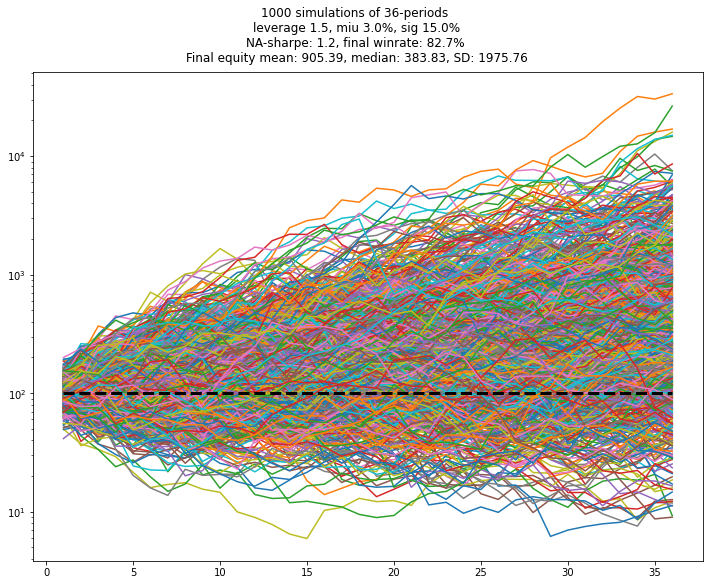

In [11]:
plotSim_normalPL(getSim_normalFixLev, initAmount1, lev1, miu1, sig1, numPeriod1, numSim1)

### Reduce  `sig` with everything else unchanged

In [ ]:
sig2 = 0.1
plotSim_normalPL(getSim_normalFixLev, initAmount1, lev1, miu1, sig1, numPeriod1, numSim1)
plotSim_fixLev(initAmount1, lev1, miu1, sig2, numPeriod1, numSim1)

### Raise both `miu` & `sig` but keeps NA-sharpe and leverage unchanged

In [ ]:
sharpe1 = 1.2 / (numPeriod1 ** 0.5)
miu3 = 0.06
sig3 = sig1 * miu3 / miu1

plotSim_fixLev(initAmount1, lev1, miu3, sig3, numPeriod1, numSim1)


### Function to check MDD

In [ ]:
def getSimMDD(dfSim, levelsMDD=(0.2, 0.5, 0.8, 0.9)):
    """Obtain percentage of simulations with final amount dropping below the given equity threshold."""
    # Transpose the simulation dataframe
    dfSimT = dfSim.transpose()
    numTrials = dfSim.shape[1]
    numSim = dfSim.shape[0]
    # Compute MDD
    dfMDD = pd.DataFrame(columns=dfSimT.columns)
    for col in dfSimT.columns:
        dfMDD[col] = (dfSimT[col] / dfSimT[col].cummax() - 1).cummin()
    # Tranpose back to match original shape
    dfMDD = dfMDD.transpose()
    # Compute percentage of simulations having MDD greater than the levels
    dictMDD = {}
    for value in levelsMDD:
        dictMDD[value] = dfMDD[dfMDD[numTrials] <= -value].shape[0] / numSim

    return dfMDD, dictMDD

### Using example 1

In [ ]:
dfMDD1, dictMDD1 = getSimMDD(dfSim1)
print(f'Percentage of betting series suffering \n')

for key, value in dictMDD1.items():
    print(f'{round(100*key)}% MDD: {round(100*value, 2)}%')

### Using example 3

In [ ]:
dfSim3, dictKPI3 = getSimKPI_fixLev(initAmount1, lev1, miu3, sig3, numPeriod1, numSim1) 

dfMDD3, dictMDD3 = getSimMDD(dfSim3)
print(f'Percentage of betting series suffering \n')

for key, value in dictMDD3.items():
    print(f'{round(100*key)}% MDD: {round(100*value, 2)}%')

## Optimal leverage (Kelly formula of continuous returns)

### Expected geometric growth (for normally distributed returns)

- Reference: Edward Thorp, The Kelly Criterion in Blackjack, Sports Betting, and the Stock Market (1997)

In [ ]:
def getNormalGrowth(lev=1.00, miu=0.03, sig=0.15, n=1):
    """Obtain expected geometric returns of random walk returns."""
    logGrowth = lev * (miu - sig ** 2 * lev / 2)

    return np.exp(n * logGrowth)

def plotNormalGrowth(miu=0.03, sig=0.15, n=1, levMin=0.20, levMax=4.0, step=0.001):
    """Plot expected geometric growth given miu & sigma, and identify optimal leverage."""
    # Form pandas Series of expected return of varying leverage
    arrLev = np.arange(levMin, levMax, step)
    dictGrowth = {lev: getNormalGrowth(lev, miu, sig, n) for lev in arrLev}
    dfGrowth = pd.DataFrame(pd.Series(dictGrowth))
    # Plot interactive diagram of f-percent curve
    fig = px.line(x=dfGrowth.index, y=dfGrowth[0], labels={'x': 'lev', 'y': f'growth factor on {n} periods'})
    fig.add_trace(go.Scatter(x=dfGrowth.index, y=np.repeat(0, len(arrLev)), name='0%'))
    # Identify optimal leverage
    bestLev = round(dfGrowth[0].idxmax(), 4)
    bestGrowth = round(dfGrowth[0].max(), 4)
    fig.add_trace(go.Scatter(x=(bestLev, ), y=(bestGrowth, ), line_color='green', name='Opt-lev', mode='markers+text',
                             marker_size=10, text=f'{bestLev, round(bestGrowth, 4)}', textposition='bottom center'))
    # Title
    fig.update_layout(title=f'Expected geometric growoth of N({miu}, {sig})', title_x=0.5, width=1000, height=500)
    # Show diagram
    fig.show()

### Example 1

In [ ]:
getNormalGrowth(lev1, miu1, sig1, numPeriod1)

In [ ]:
plotNormalGrowth(miu1, sig1, numPeriod1)

### Example 2

In [ ]:
plotNormalGrowth(miu1, sig2, numPeriod1, 1.0, 5.0)

### Example 3

In [ ]:
plotNormalGrowth(miu3, sig3, numPeriod1, 0.2, 2.0)

### Kelly optimal leverage (for normally distributed returns ONLY)

In [ ]:
def getkellyLev(miu, sig):
    """Obtain Kelly formula of optimal leverage."""
    return round(max(miu / sig**2, 0), 4)

### Kelly leverage for a bunch of (`miu`, `sig`) pairs

- reasonable range of monthly returns: 0.5% - 5%  (annualized log-returns: 6% - 60%)
- reasonable range of monthly volatility: 6% - 40%  (annualized volatility:  20% - 140%)

In [ ]:
miuArray = np.arange(0.5, 4.5, 0.5) / 100
sigArray = np.arange(0.2, 1.5, 0.12) / (12 ** 0.5)
numMonth = 36

dfLev = pd.DataFrame()
dfSharpe = pd.DataFrame()
dfAmount = pd.DataFrame()

for miu, sig in product(miuArray, sigArray):
    optLev = round(miu / sig ** 2, 4)
    dfLev.loc[f'{round(100*miu, 2)}%', f'{round(100*sig, 2)}%'] = optLev
    dfSharpe.loc[f'{round(100*miu, 2)}%', f'{round(100*sig, 2)}%'] = round(miu / sig * (numMonth ** 0.5), 4)
    dfAmount.loc[f'{round(100*miu, 2)}%', f'{round(100*sig, 2)}%'] = round(100 * getNormalGrowth(optLev, miu, sig, numMonth), 2)

dfLev

### NA-sharpe for the above (`miu`, `sig`) pairs

In [ ]:
dfSharpe

### Expected final equity on optimal leverage

In [ ]:
dfAmount

## Adopt real stock price and check historical results on using leverage

### Collecting OHLC data

In [ ]:
import yfinance as yf

def getYahooData(symbolList, adjust=True, startStr='1990-01-01', endStr='2046-12-31'):
    """Scrape via yahoo API to obtain data for a symbolList."""
    symbolStr = ' '.join(symbolList)
    renameDict = {'Date': 'date', 'Open': 'op', 'High': 'hi', 'Low': 'lo', 'Close': 'cl',
                  'Volume': 'vol', 'Adj Close': 'adj_cl', 'Dividends': 'div', 'Stock Splits': 'split'}
    priceFields = ['op', 'hi', 'lo', 'cl']
    dataFields = priceFields + ['vol', 'div']

    dataDict = {}

    try:
        dfData = yf.download(symbolStr, start=startStr, end=endStr, auto_adjust=False, actions=True,
                             group_by='Tickers', threads=16)
    except:
        dfData = pd.DataFrame()

    for symbol in symbolList:
        try:
            dfSymbol = dfData[(symbol,)].dropna()  # Raw data for the symbol
            dfSymbol = dfSymbol[(dfSymbol['Volume'] > 0) | (dfSymbol['High'] > dfSymbol['Low'])]  # Filter bad data
            dfSymbol.reset_index(inplace=True)
            dfSymbol.rename(columns=renameDict, inplace=True)
            dfSymbol.set_index('date', inplace=True)

            if not adjust:
                dfSymbol = dfSymbol[dataFields]
                dfSymbol.rename(columns={field: f'{symbol}_{field}' for field in dataFields}, inplace=True)
            else:
                adjfactor = dfSymbol['adj_cl'] / dfSymbol['cl']
                for field in priceFields:
                    dfSymbol[f'adj_{field}'] = dfSymbol[field] * adjfactor
                dfSymbol['adj_vol'] = dfSymbol['vol'] / adjfactor
                dfSymbol = dfSymbol[[f'adj_{field}' for field in dataFields[:-1]]]
                dfSymbol.rename(columns={f'adj_{field}': f'{symbol}_{field}' for field in dataFields[:-1]}, inplace=True)
                dfSymbol = np.round(dfSymbol, 4)

            dataDict[symbol] = dfSymbol
        except:
            print(f'Failed preparing data for {symbol}.')

    dfAll = pd.concat(dataDict.values(), axis=1, join='inner')
    dfAll.fillna(method='ffill', inplace=True)

    return dfAll

In [ ]:
symbolList = ['SPY', 'QQQ', 'IWM', 'ARKK', 'EWH', 'AAPL', 'MSFT', 'NVDA', 'TSLA', 'AMZN', 'JPM']

startStr = '2011-01-01'
endStr = '2023-01-01'
dfAll = getYahooData(symbolList, True, startStr, endStr)

### Resample into monthly OHLC

In [ ]:
def resampleOHLC(dfData, symbolList, freq='M'):
    """Resample the OHLC dataframe into desired timeframe."""
    ruleDict = {}
    for asset in symbolList:
        symbolDict = {f'{asset}_op': 'first', f'{asset}_cl': 'last',
                      f'{asset}_hi': 'max', f'{asset}_lo': 'min', f'{asset}_vol': 'sum'}
        ruleDict.update(symbolDict)

    dfData1 = dfData.resample(rule=freq, label='right').agg(ruleDict)

    return dfData1

dfAll_month = resampleOHLC(dfAll, symbolList)
dfAll_month.iloc[-12:, :10]

### Compute optimal leverage of all symbols in every 36-month-period

In [ ]:
numMonth = 36
startStr1 = dfAll_month.index[-1 - numMonth].strftime('%Y-%m-%d')
endStr1 = dfAll_month.index[-1].strftime('%Y-%m-%d')

dfOptLev = pd.DataFrame()
dfPct = pd.DataFrame()

for symbol in symbolList:
    dfMonth = dfAll_month.loc[startStr1:endStr1, [f'{symbol}_cl']]
    dfPct[f'{symbol}_pct'] = np.round(np.log(dfMonth[f'{symbol}_cl'] / dfMonth[f'{symbol}_cl'].shift(1)), 5)
    dfPct[f'{symbol}_chg'] = np.round(dfMonth[f'{symbol}_cl'] / dfMonth[f'{symbol}_cl'].shift(1) - 1, 5)
    dfOptLev.loc[symbol, 'miu'] = round(dfPct[f'{symbol}_pct'].mean(), 5)
    dfOptLev.loc[symbol, 'sig'] = round(dfPct[f'{symbol}_pct'].std(), 5)
    dfOptLev.loc[symbol, 'NAsharpe'] = \
         round(dfOptLev.loc[symbol, 'miu'] / dfOptLev.loc[symbol, 'sig'] * (numMonth ** 0.5), 4)
    dfOptLev.loc[symbol, 'optLev'] = getkellyLev(dfOptLev.loc[symbol, 'miu'], dfOptLev.loc[symbol, 'sig'])
    
dfOptLev

### 1x leverage cumulative returns

In [ ]:
dfNAV_1x = pd.DataFrame(index=dfPct.index)

for symbol in symbolList:
    dfNAV_1x[f'{symbol}_NAV'] = (1 + dfPct[f'{symbol}_chg']).cumprod()

dfNAV_1x.iloc[0] = 1.00

for symbol in symbolList:
    dfNAV_1x[f'{symbol}_DD'] = dfNAV_1x[f'{symbol}_NAV'] / dfNAV_1x[f'{symbol}_NAV'].cummax() - 1
    dfNAV_1x[f'{symbol}_MDD'] = dfNAV_1x[f'{symbol}_DD'].cummin()

productFields = product(symbolList, ['NAV', 'DD', 'MDD'])
dfNAV_1x = dfNAV_1x[[f'{symbol}_{field}' for symbol, field in productFields]]
    
dfNAV_1x.iloc[-6:, :12]

### Append 1x return statistics to optlev dataframe

In [ ]:
for symbol, field in product(symbolList, ['NAV', 'MDD']):
    dfOptLev.loc[symbol, f'{field}_1x'] = dfNAV_1x.loc[endStr1, f'{symbol}_{field}']

dfOptLev

### Adopt optimal leverage to past 36 months

In [ ]:
symbolList_win = [symbol for symbol in symbolList if dfOptLev.loc[symbol, 'optLev'] > 0]
dfNAV_optLev = pd.DataFrame(index=dfPct.index)

for symbol in symbolList_win:
    dfNAV_optLev[f'{symbol}_NAV'] = (1 + dfOptLev.loc[symbol, 'optLev'] * dfPct[f'{symbol}_chg']).cumprod()

dfNAV_optLev.iloc[0] = 1.0

for i in range(dfNAV_optLev.shape[1]):
    for j in range(dfNAV_optLev.shape[0]):
        if dfNAV_optLev.iloc[j, i] <= 0:
            dfNAV_optLev.iloc[j:, i] = dfNAV_optLev.iloc[j, i]

for symbol in symbolList_win:
    dfNAV_optLev[f'{symbol}_DD'] = dfNAV_optLev[f'{symbol}_NAV'] / dfNAV_optLev[f'{symbol}_NAV'].cummax() - 1
    dfNAV_optLev[f'{symbol}_MDD'] = dfNAV_optLev[f'{symbol}_DD'].cummin()

productFields_win = product(symbolList_win, ['NAV', 'DD', 'MDD'])
dfNAV_optLev = dfNAV_optLev[[f'{symbol}_{field}' for symbol, field in productFields_win]]

for symbol in symbolList:
    if symbol in symbolList_win:
        dfOptLev.loc[symbol, 'optNAV'] = dfNAV_optLev.loc[endStr1, f'{symbol}_NAV']
        dfOptLev.loc[symbol, 'optMDD'] = dfNAV_optLev.loc[endStr1, f'{symbol}_MDD']
    else:
        dfOptLev.loc[symbol, 'optNAV'] = 1.000
        dfOptLev.loc[symbol, 'optMDD'] = 0.000
        
dfOptLev

### Search opt-lev from historical returns instead of Kelly formula

In [ ]:
dfOptLev_real = dfOptLev[['miu', 'sig', 'NAsharpe', 'optLev']]
dfOptLev_real.rename(columns={'miu': 'month_miu', 'sig': 'month_sig'}, inplace=True)

dfOptLev_real['optNAV'] = 1.000
dfOptLev_real['optMDD'] = 0.000

levArray = np.arange(0.2, 3.05, 0.05)

for lev in levArray:
    dfNAV_real = pd.DataFrame(index=dfPct.index)

    for symbol in symbolList:
        dfNAV_real[f'{symbol}_NAV'] = (1 + lev * dfPct[f'{symbol}_chg']).cumprod()

    dfNAV_real.iloc[0] = 1.0

    for i in range(dfNAV_real.shape[1]):
        for j in range(dfNAV_real.shape[0]):
            if dfNAV_real.iloc[j, i] <= 0:
                dfNAV_real.iloc[j:, i] = dfNAV_real.iloc[j, i]

    for symbol in symbolList:
        dfNAV_real[f'{symbol}_DD'] = dfNAV_real[f'{symbol}_NAV'] / dfNAV_real[f'{symbol}_NAV'].cummax() - 1
        dfNAV_real[f'{symbol}_MDD'] = dfNAV_real[f'{symbol}_DD'].cummin()

        if dfNAV_real[f'{symbol}_NAV'][-1] > dfOptLev_real.loc[symbol, 'optNAV']:
            dfOptLev_real.loc[symbol, 'optNAV'] = dfNAV_real[f'{symbol}_NAV'][-1]
            dfOptLev_real.loc[symbol, 'optMDD'] = dfNAV_real[f'{symbol}_MDD'][-1]
            dfOptLev_real.loc[symbol, 'optlev'] = lev

    print(f'{round(lev, 2)}x buy-hold-rebalance done.')

In [ ]:
dfOptLev_real